# Batch Normalization with the MNIST Dataset

<h2>Table of Contents</h2>
In this notebook, we will build a Neural Network using Batch Normalization and compare it to a Neural Network that does not use Batch Normalization. We will use the MNIST dataset to test your network. 

<ul>
<li><a href="#Train_Func">Neural Network Module and Training Function</a></li>
<li><a href="#Makeup_Data">Load Data </a></li>
<li><a href="#NN">Define Several Neural Networks, Criterion function, Optimizer</a></li>
<li><a href="#Train">Train Neural Network using Batch Normalization and no Batch Normalization</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
</div>

<hr>


In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

In [11]:
class NetBatchNorm(nn.Module):
    
    # Constructor:
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1) 
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    # Prediction:
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x))) # Check Notes for details
        x = self.bn2(torch.sigmoid(self.linear2(x))) # Check Notes for details
        x = self.linear3(x)
        return x
    
    # Activation to analyze results
    def activation(self,x):
        out = []
        z1 = self.bn1(self.linear1(x))
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1))
        z2 = self.bn2(self.linear2(a1))
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out

**Note**

It is generally recommended to apply batch normalization before the activation function in a neural network. This is because the normalization step helps the model learn the appropriate scale and distribution of the inputs to the activation function, which can improve the model's ability to learn and generalize. Additionally, by normalizing the inputs to the activation function, you can use a larger learning rate, which can speed up training.

However, there are some cases where applying batch normalization after the activation function can be beneficial. For example, if you are using a saturating activation function, such as a sigmoid or tanh, batch normalization after the activation function can help to prevent the outputs of the activation function from saturating, which can improve the model's ability to learn.

In the end, the choice of whether to apply batch normalization before or after the activation function will depend on your specific model and the dataset you are using. It's always a good idea to experiment with different configurations and see what works best for your particular scenario.

In [12]:
# Class Net for Neural Network Model

class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out 

In [13]:
# Define the function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            model.eval()
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

**Make some data**

In [14]:
# load the train dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# load the train dataset

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create Data Loader for both train and validating

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a id="ref3"></a>
<h2 align=center>Define Neural Network, Criterion function, Optimizer and Train the  Model  </h2> 


In [15]:
# Create the criterion function

criterion = nn.CrossEntropyLoss()

# Set the parameters

input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

<h2 id="Train">Train Neural Network using Batch Normalization and no Batch Normalization </h2> 

In [16]:
# Create model, optimizer and train the model

model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)
training_results_Norm=train(model_norm , criterion, train_loader, validation_loader, optimizer, epochs=5)

# Create model without Batch Normalization, optimizer and train the model

model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

<h2 id="Result">Analyze Results</h2> 


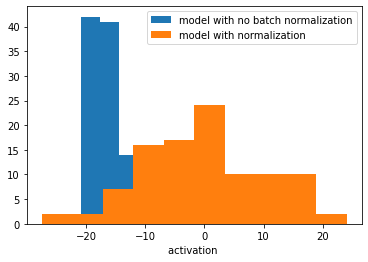

In [17]:
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2],label='model with no batch normalization' )
out_norm=model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2],label='model with normalization')
plt.xlabel("activation ")
plt.legend()
plt.show()

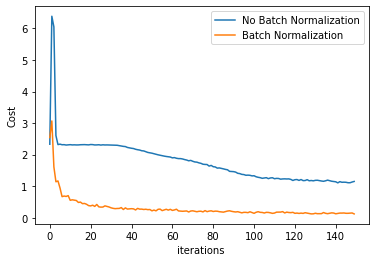

In [18]:
# Plot the diagram to show the loss

plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

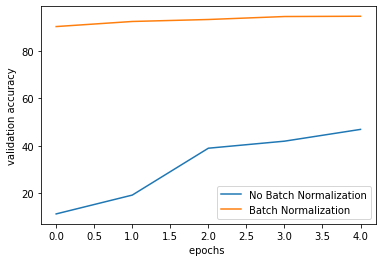

In [19]:
# Plot the diagram to show the accuracy

plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()